In [1]:
"""
Title: Full Preprocessing, Feature Engineering, and Model Evaluation Pipeline for Hospital Bed Utilization

Description:
This script performs an end-to-end data science workflow to analyze and model hospital bed utilization rates
using social determinants of health (SDOH), geographic access features, and environmental context. The pipeline includes:

1. Data Loading and Initial Exploration
2. Preprocessing and Filtering:
   - Region/State exclusions
   - Missing value handling
3. Feature Engineering:
   - One-hot encoding (Region)
   - Binary encoding + KNN Imputation (Is_Metro_Micro)
   - Standardization (numerical features)
4. Train-Test Splitting using calculated optimal ratio
5. Target Normalization using Box-Cox Transformation
6. Dimensionality Reduction using PCA (optional branch)
7. Predictive Modeling:
   - Ridge and Lasso Regression
   - SVR, Random Forest, Gradient Boosting, and XGBoost
   - With and without PCA-based dimensionality reduction
8. Hyperparameter Tuning:
   - GridSearchCV for all major models (SVR, RF, GB, XGB)
   - Extended grids for top-performing models
   - Regularization and subsampling (XGBoost) for overfitting control
9. Performance Evaluation:
   - RMSE, R², MAE on both transformed and original target scales
   - Residual diagnostics (Shapiro-Wilk, Q-Q, KDE)
   - PCA component analysis and feature loadings (if applicable)
10. Export of:
   - Full encoded/imputed dataset with preserved missing targets
   - Cleaned modeling-only dataset

Inputs:
- 'MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv': Raw merged dataset with renamed variables

Outputs:
- 'final_full_dataset_with_preserved_missing_targets.xlsx': Encoded and imputed full dataset
- 'modeling_dataset_only.xlsx': Cleaned modeling dataset without missing target
- Diagnostic plots and model evaluation visualizations

Note:
- Target variable: 'Bed_util_ratio'
- Special handling applied to: Is_Metro_Micro, State, and Region
- Models evaluated both with and without PCA
- Final tuning and selection based on test generalization performance
"""




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Data Loading and Initial Exploration

In [2]:
df = pd.read_csv('MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountyFIPS,3239.0,31504.662550,16462.990939,1001.000000,19032.000000,30033.000000,46126.000000,7.803000e+04
Pct_renter_occupied,3234.0,26.781928,9.633306,0.000000,21.333333,26.000000,31.798276,8.200000e+01
Distance_to_medsurge_icu,3234.0,12.573051,17.665270,0.000000,4.666666,7.300000,16.500000,4.870000e+02
Pct_renter_cost_50pct_plus,3234.0,18.632206,7.791009,0.000000,14.283193,18.836021,23.285714,7.500000e+01
Pct_renter_cost_30pct_plus,3234.0,39.682482,12.036717,0.000000,34.000000,41.000000,46.761029,1.000000e+02
Total_population_poverty,3234.0,98504.677798,322472.553341,0.000000,9612.250000,23553.000000,63324.000000,9.884138e+06
Pct_owner_cost_30plus,3234.0,17.706173,5.730589,0.000000,14.833333,17.500000,20.698997,4.275000e+01
Population_density,3234.0,891.208574,2798.157565,0.000000,41.525000,209.100000,907.020161,9.038623e+04
Land_area_sqmi,3234.0,289.385427,1296.982616,0.000000,27.857143,72.000000,173.317307,3.639325e+04
Median_hh_income,3234.0,53803.784787,17732.176889,0.000000,44620.500000,52881.500000,61834.750000,1.485230e+05


In [5]:
df.isna().sum()

,0
CountyFIPS,0
State,0
County,5
Region,96
Pct_renter_occupied,5
Distance_to_medsurge_icu,5
Pct_renter_cost_50pct_plus,5
Pct_renter_cost_30pct_plus,5
Total_population_poverty,5
Pct_owner_cost_30plus,5


In [6]:
# Display structure and summary
print(df.shape)
print(df.dtypes.value_counts())

(3239, 24)
float64    20
object      3
int64       1
Name: count, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

# Preprocessing, Encoding, Imputation

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# --- 1. Load and Initial Cleaning ---
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

# Drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=["State", "Land_area_sqmi", "Pct_renter_cost_30pct_plus"], errors="ignore")

# Drop rows with missing predictor values (except for Is_Metro_Micro and Bed_util_ratio)
predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# --- 2. Split modeling vs missing target ---
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# --- 3. Train-Test Split ---
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]

split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# --- 4. Encoding ---
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)

# Align columns between train and test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County"], errors="ignore")
X_test = X_test.drop(columns=["CountyFIPS", "County"], errors="ignore")

# --- 5. Scaling and Imputation ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# --- 6. Reattach Targets ---
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# --- 7. Handle missing-target dataset ---
df_missing_target_encoded = df_missing_target.copy()

df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)

df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

df_missing_scaled = df_missing_target_encoded.copy()
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)

df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# --- 8. Combine Full Dataset ---
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# --- 9. Export ---
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 21)
Rows with missing Bed_util_ratio preserved separately: (751, 21)

Calculated train/test split: 0.78/0.22

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.425206                 -0.471017                    1.383843   
1            -0.699455                 -0.248219                    0.014196   
2             1.178700                 -0.127155                    0.188555   
3            -0.479857                  1.178608                    1.290080   
4            -0.534053                 -0.014738                    0.638884   

   Total_population_poverty  Pct_owner_cost_30plus  Population_density  \
0                 -0.184447               0.243717           -0.032985   
1                  0.265340               0.379438           -0.254184   
2                 -0.277534              -0.447575  

In [9]:
print([col for col in df_cleaned.columns if "Land" in col])


[]


In [10]:
X_train_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0
Pct_homes_no_vehicle,0


In [11]:
X_test_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Median_hh_income,0
Pct_hh_65_alone,0
Pct_age_65plus,0
Pct_homes_no_vehicle,0


In [12]:
len(X_train_scaled), len(X_test_scaled)

(1864, 527)

## Evaluation

### Histogram of Bed_util_ratio - Train vs Test (No Imputation)

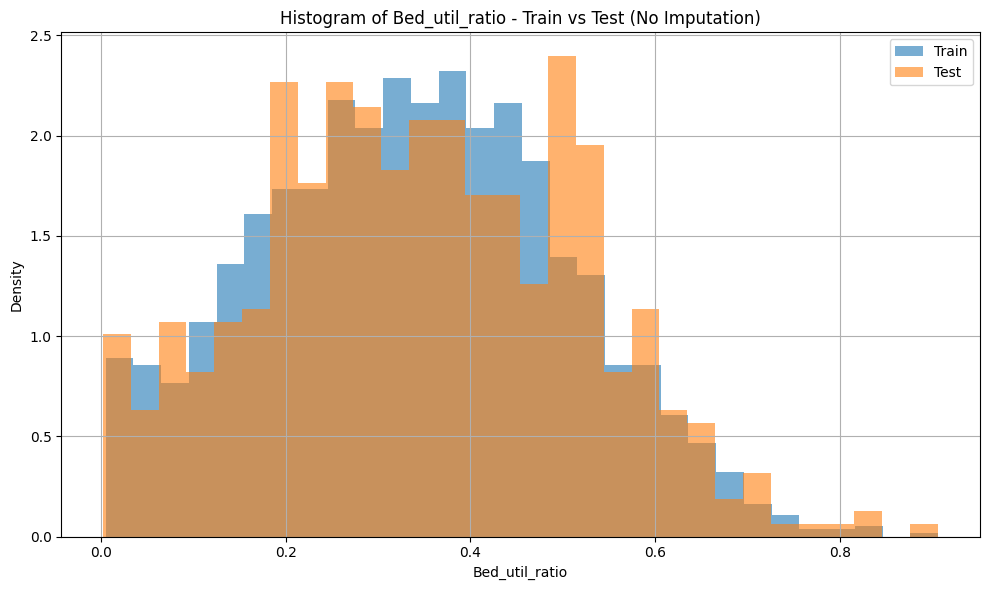

In [13]:
# === Histogram of Bed_util_ratio - Train vs Test (No Imputation) ===
plt.figure(figsize=(10, 6))
plt.hist(train_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Train", density=True)
plt.hist(test_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Test", density=True)
plt.title("Histogram of Bed_util_ratio - Train vs Test (No Imputation)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### BarPlot - Imputation Comparison for Is_Metro_Micro

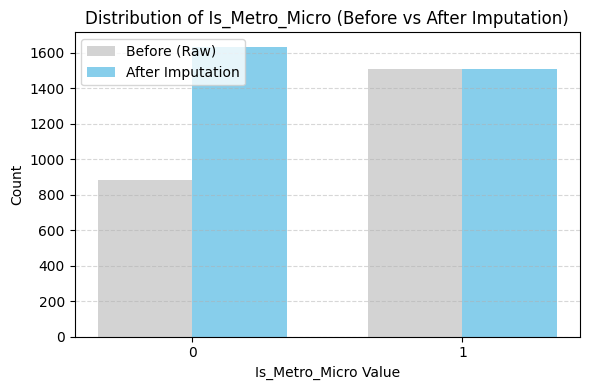

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Before imputation: include NaNs
before = df_cleaned["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan}).value_counts(dropna=False)
before.index = before.index.astype("object")  # so NaN label is retained

# After imputation: should be only 0 and 1
after = df_final_full["Is_Metro_Micro"].value_counts()

# Align both to 0 and 1 only (for bar chart)
x_labels = [0, 1]
before_aligned = [before.get(0, 0), before.get(1, 0)]
after_aligned = [after.get(0, 0), after.get(1, 0)]

# Plot
bar_width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before_aligned, width=bar_width, label="Before (Raw)", color="lightgray")
plt.bar(x + bar_width/2, after_aligned, width=bar_width, label="After Imputation", color="skyblue")

plt.xticks(ticks=x, labels=["0", "1"])
plt.xlabel("Is_Metro_Micro Value")
plt.ylabel("Count")
plt.title("Distribution of Is_Metro_Micro (Before vs After Imputation)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Shapiro-Wilk W Statistic for Bed_util_ratio

In [15]:
from scipy.stats import shapiro

# Run only on non-null values
target_values = df_final_full["Bed_util_ratio"].dropna()

# Perform Shapiro-Wilk test
stat, p = shapiro(target_values)

print("Shapiro-Wilk W Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")


Shapiro-Wilk W Statistic: 0.9919237932068726
p-value: 2.821064526072581e-10
Target likely not normally distributed (reject H0)


In [16]:
Shapiro_Result = """We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. \nThe resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. \nThis insight may inform downstream modeling choices (e.g., transformation before regularized regression). \nSince our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), \nwe retained the raw distribution of the target for now."""
print(Shapiro_Result)

We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. 
The resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. 
This insight may inform downstream modeling choices (e.g., transformation before regularized regression). 
Since our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), 
we retained the raw distribution of the target for now.


### Distribution of Bed_Util_Ratio w/ KDE

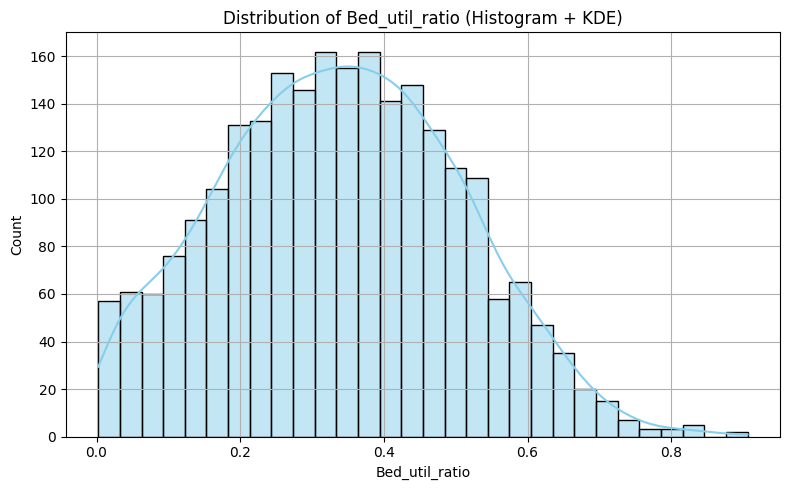

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(bed_util_values, kde=True, bins=30, color="skyblue")
plt.title("Distribution of Bed_util_ratio (Histogram + KDE)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### Q-Q Plot for Normality Check

<Figure size 600x600 with 0 Axes>

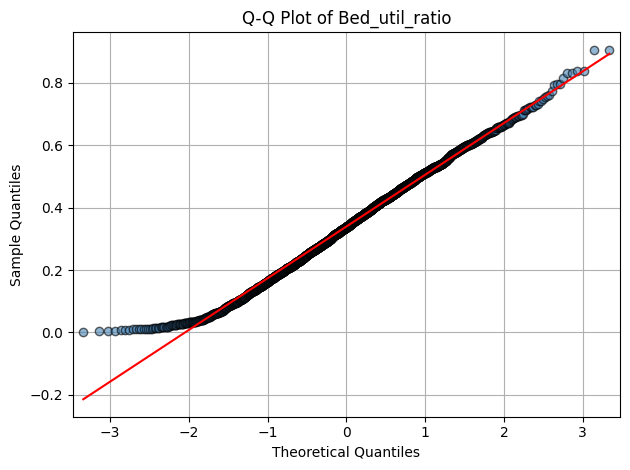

In [18]:
import statsmodels.api as sm
import scipy.stats as stats

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# QQ plot
plt.figure(figsize=(6, 6))
sm.qqplot(bed_util_values, line="s", markerfacecolor='steelblue', markeredgecolor='black', alpha=0.6)
plt.title("Q-Q Plot of Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


# PCA

## PCA Setup with Box-Cox Transformation

Box-Cox Lambda: 0.7989


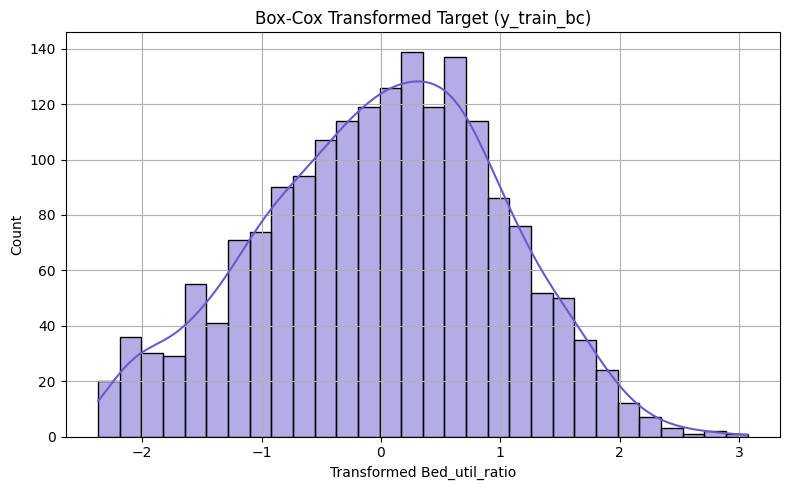

Shapiro-Wilk Test for Normality of Transformed Target:
W = 0.9930, p = 0.0000
Transformed target likely not normal.


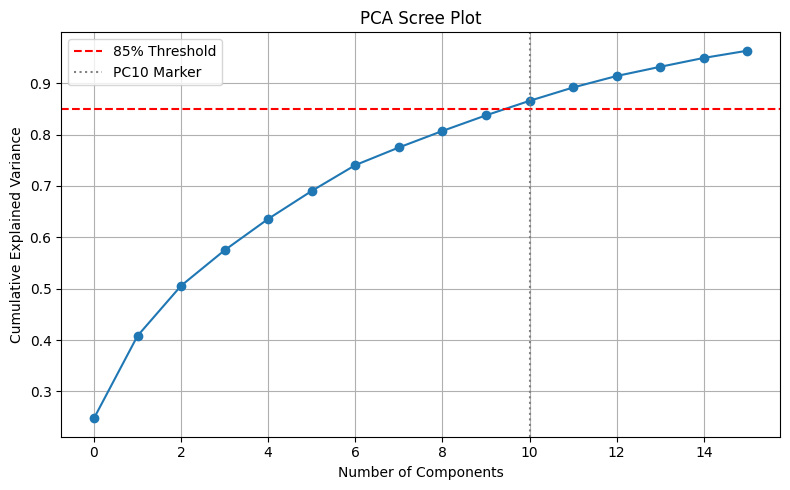

,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.247705,0.247705
1,PC2,0.160430,0.408134
2,PC3,0.097567,0.505701
3,PC4,0.069142,0.574843
4,PC5,0.060934,0.635777
5,PC6,0.054443,0.690219
6,PC7,0.050238,0.740458
7,PC8,0.034305,0.774763
8,PC9,0.032176,0.806939
9,PC10,0.030380,0.837318


Original shape (X_train_scaled): (1864, 20)
Reduced shape after PCA (train): (1864, 16)
Reduced shape after PCA (test): (527, 16)


In [19]:
"""
This cell continues from the preprocessing pipeline and assumes the following
variables are already defined:
- X_train_scaled, X_test_scaled: scaled feature sets (with no missing values)
- y_train, y_test: untransformed target values (may include small or non-positive values)

This step performs:
- Box-Cox transformation on the target (Bed_util_ratio) to correct skewness and approximate normality
    - Applies safe shifting for Box-Cox if any values are ≤ 0
    - Includes diagnostic checks: histogram and Shapiro-Wilk test
- Principal Component Analysis (PCA) on the scaled features to reduce dimensionality
    - Retains enough components to explain ≥95% of variance
    - Visualizes cumulative explained variance via a scree plot

Final outputs:
- Transformed target: y_train_bc, y_test_bc
- Reduced feature sets: X_train_pca, X_test_pca
- Diagnostic outputs for lambda, distribution, normality, and variance retention
"""


# --- Box-Cox Transformation + PCA Setup ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.special import inv_boxcox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Shift the target if needed (Box-Cox requires strictly positive values)
if (y_train <= 0).any():
    shift_amount = abs(y_train.min()) + 0.01
    y_train_shifted = y_train + shift_amount
    y_test_shifted = y_test + shift_amount
else:
    shift_amount = 0
    y_train_shifted = y_train
    y_test_shifted = y_test

# Apply Box-Cox
pt = PowerTransformer(method='box-cox')
y_train_bc = pt.fit_transform(y_train_shifted.values.reshape(-1, 1)).flatten()
y_test_bc = pt.transform(y_test_shifted.values.reshape(-1, 1)).flatten()
lambda_bc = pt.lambdas_[0]

# ----------------------
# Box-Cox Diagnostic Output

print(f"Box-Cox Lambda: {lambda_bc:.4f}")

# Histogram of Box-Cox Transformed Target
plt.figure(figsize=(8, 5))
sns.histplot(y_train_bc, bins=30, kde=True, color='slateblue')
plt.title("Box-Cox Transformed Target (y_train_bc)")
plt.xlabel("Transformed Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

stat_bc, p_bc = shapiro(y_train_bc)
print(f"Shapiro-Wilk Test for Normality of Transformed Target:")
print(f"W = {stat_bc:.4f}, p = {p_bc:.4f}")
if p_bc > 0.05:
    print("Transformed target appears approximately normal.")
else:
    print("Transformed target likely not normal.")

# ----------------------
# ------------PCA----------------

# PCA on scaled features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.axhline(y=0.85, color='r', linestyle='--', label='85% Threshold')
plt.axvline(x=10, color='grey', linestyle='dotted', label='PC10 Marker')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# View explained variance (optional)
explained_variance = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": np.cumsum(pca.explained_variance_ratio_)
})
display(explained_variance.head(10))

# --- Final Output ---
# Inspect original shape ---
print("Original shape (X_train_scaled):", X_train_scaled.shape)
print("Reduced shape after PCA (train):", X_train_pca.shape)
print("Reduced shape after PCA (test):", X_test_pca.shape)



## PCA Plots with Loadings

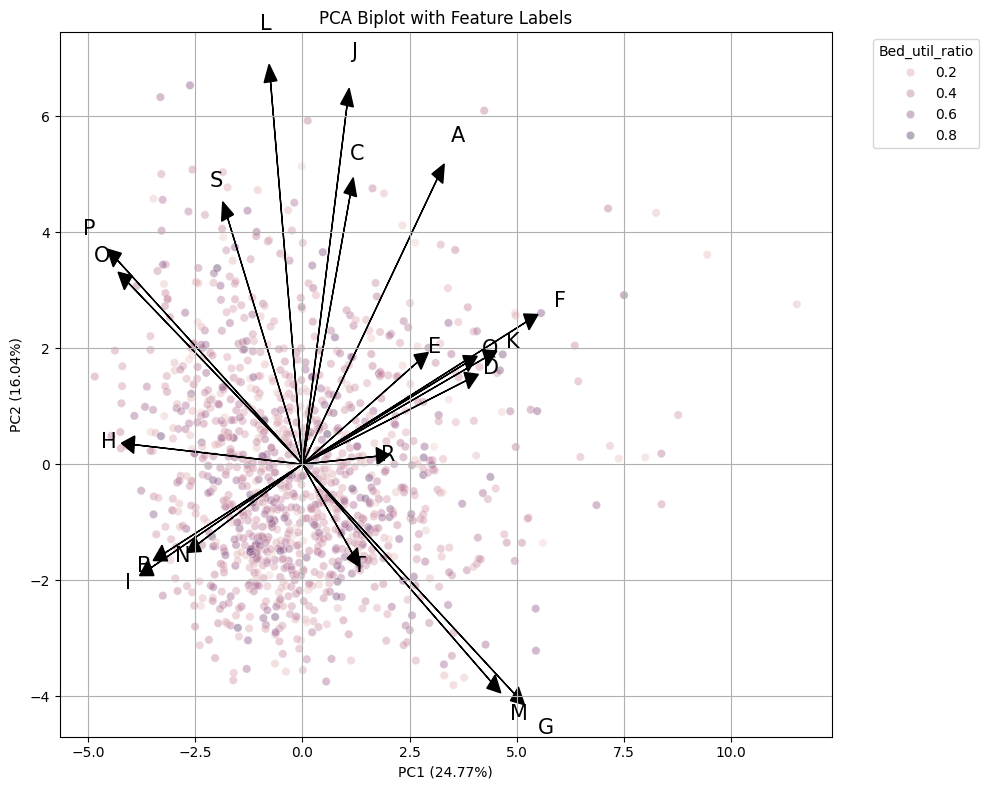

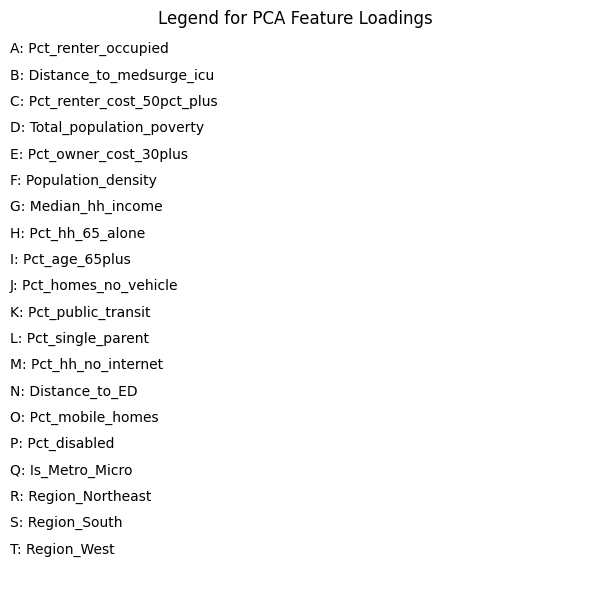

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import string


#our variables
feature_names = X_train_scaled.columns.tolist()

# Create PCA DataFrame for plotting using df_final_full
pca_df = pd.DataFrame(X_train_pca[:, :2], columns=["PC1", "PC2"])

# Loadings for the first two components
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=["PC1", "PC2"],
    index=X_train_scaled.columns
)

# Generate label map based on PCA loadings (actual features used)
feature_names = loadings.index.tolist()
feature_labels = list(string.ascii_uppercase[:len(feature_names)])
label_map = dict(zip(feature_names, feature_labels))



# Define the loading_plot function
def loading_plot(coeff, labels, scale=6, colors=None, visible=None, ax=plt, arrow_size=0.05, font_size=12):
  for i, label in enumerate(labels):
      if visible is None or visible[i]:
          ax.arrow(0, 0,
                    coeff[i, 0] * scale,
                    coeff[i, 1] * scale,
                    head_width=arrow_size * scale,
                    head_length=arrow_size * scale,
                    color="#000" if colors is None else colors[i])
          ax.text(coeff[i, 0] * 1.15 * scale,
                  coeff[i, 1] * 1.15 * scale,
                  label_map.get(label, label),  # Safe fallback
                  color="#000" if colors is None else colors[i],
                  ha="center", va="center", fontsize=font_size)




# Plot PCA biplot with feature loadings
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, hue=df_final_full.loc[X_train_scaled.index, "Bed_util_ratio"], alpha=0.4)
loading_plot(loadings.values, labels=loadings.index, scale=15, arrow_size=0.02, font_size=15)


# Add axis labels and title
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot with Feature Labels")

# Add a legend in the top right corner for Bed_util_ratio
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title='Bed_util_ratio')

# Show grid and finalize plot layout
plt.grid(True)
plt.tight_layout()
plt.show()

# Create legend
legend_labels = [f"{label_map.get(name, name)}: {name}" for name in feature_names]


plt.figure(figsize=(6, len(legend_labels) * 0.3))
plt.axis('off')
for i, txt in enumerate(legend_labels):
    plt.text(0, 1 - i * 0.05, txt, fontsize=10)
plt.title("Legend for PCA Feature Loadings\n", fontsize=12)
plt.tight_layout()

plt.show()

## View - Top Predicters for PC1 only

In [21]:
"""
This cell analyzes the contribution of original features to the first 10 principal components generated by PCA.

Purpose:
- To interpret what the principal components represent in terms of the original features
- To identify which features most strongly influence each component, especially PC1

Steps performed:
- Converts the PCA-transformed NumPy array (X_train_scaled) into a labeled DataFrame using the original feature names
- Constructs a PCA loadings matrix ('loadings_df'), where:
    - Rows = Principal Components (PC1–PC10)
    - Columns = Original features
    - Cell values = correlation-like weights (loadings) showing each feature's contribution to that component
- Extracts and displays the top 10 most influential features (by absolute loading value) for the first principal component (PC1)

Interpretation:
- Features with the highest absolute loadings for PC1 are the strongest contributors to the variance captured by that component.
- This allows labeling PCs (e.g., "Urban Density and Access Barriers") and drawing real-world conclusions from otherwise abstract components.
"""

# Extract original column names from X_train before scaling
original_feature_names = X_train.columns

# Adding Column names to:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

# Automatically adjust to actual number of retained PCs
n_components = pca.n_components_

loadings_df = pd.DataFrame(
    pca.components_[:n_components],
    columns=X_scaled_df.columns,
    index=[f"PC{i+1}" for i in range(n_components)]
)


# Show top contributing features to PC1
top_pc1 = loadings_df.loc["PC1"].abs().sort_values(ascending=False)
print("Top contributing features to PC1:")
print(top_pc1.head(10))


Top contributing features to PC1:
Population_density          0.348197
Median_hh_income            0.329753
Pct_hh_no_internet          0.293295
Pct_disabled                0.287865
Pct_public_transit          0.284012
Pct_mobile_homes            0.270839
Pct_hh_65_alone             0.261613
Total_population_poverty    0.254900
Is_Metro_Micro              0.253635
Pct_age_65plus              0.235502
Name: PC1, dtype: float64


## View - Top Predicters for Top 5 Principle Components only

In [22]:
"""
Displays the top 5 contributing original features for each of the first 10 principal components.
Helps interpret what each PC represents in terms of feature influence.
"""

for pc in loadings_df.index:
    top_features = loadings_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\nTop features in {pc}:")
    print(top_features)




Top features in PC1:
Population_density    0.348197
Median_hh_income      0.329753
Pct_hh_no_internet    0.293295
Pct_disabled          0.287865
Pct_public_transit    0.284012
Name: PC1, dtype: float64

Top features in PC2:
Pct_single_parent             0.439723
Pct_homes_no_vehicle          0.412314
Pct_renter_occupied           0.328235
Pct_renter_cost_50pct_plus    0.309804
Region_South                  0.283151
Name: PC2, dtype: float64

Top features in PC3:
Pct_age_65plus           0.436337
Pct_hh_65_alone          0.399567
Pct_owner_cost_30plus    0.368368
Region_South             0.311490
Region_Northeast         0.286084
Name: PC3, dtype: float64

Top features in PC4:
Region_West              0.550446
Distance_to_ED           0.399050
Pct_mobile_homes         0.333503
Region_Northeast         0.318935
Pct_owner_cost_30plus    0.290926
Name: PC4, dtype: float64

Top features in PC5:
Distance_to_medsurge_icu      0.410629
Pct_renter_cost_50pct_plus    0.387836
Is_Metro_Micro    

## Using PCA to Identify Clusters (K-Means)

In [23]:
from sklearn.cluster import KMeans

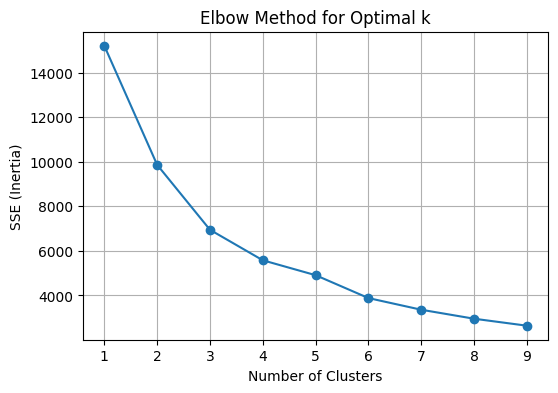

In [24]:
# elbow method for identifying 'k'
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(pca_df[["PC1", "PC2"]])
    sse.append(km.inertia_)

plt.figure(figsize = (6, 4))
plt.plot(range(1, 10), sse, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [25]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

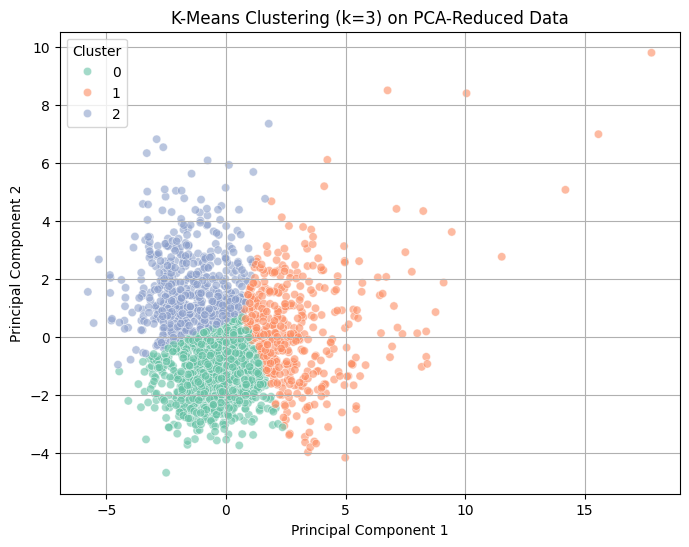

In [26]:
# Plot
plt.figure(figsize = (8, 6))
sns.scatterplot(
    x = 'PC1', y = 'PC2',
    data = pca_df,
    hue = 'Cluster',
    palette = 'Set2',
    alpha = 0.6
)
plt.title('K-Means Clustering (k=3) on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title = 'Cluster')
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

score = silhouette_score(pca_df[['PC1', 'PC2']], pca_df['Cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.349


The Silhouette Score measures how similar a point is to its own cluster vs. other clusters.

Ranges from -1 to 1.

Closer to 1 = well-clustered.

Near 0 = overlapping clusters.

Negative = misclassified points.

Our score is below 0.5, which means the structure isn't super distinct and there's likely some overlap or ambiguous boundaries between the clusters.

# Supervised/Predictive Model

## SVM Regression on Full Feature Set (No PCA)

CV R² (no PCA): 0.2981 ± 0.0272
Test RMSE: 0.8597
Test MAE:  0.6664
Test R²:   0.3280

Shapiro-Wilk (No PCA): W = 0.9944, p = 0.0519
Likely Normal


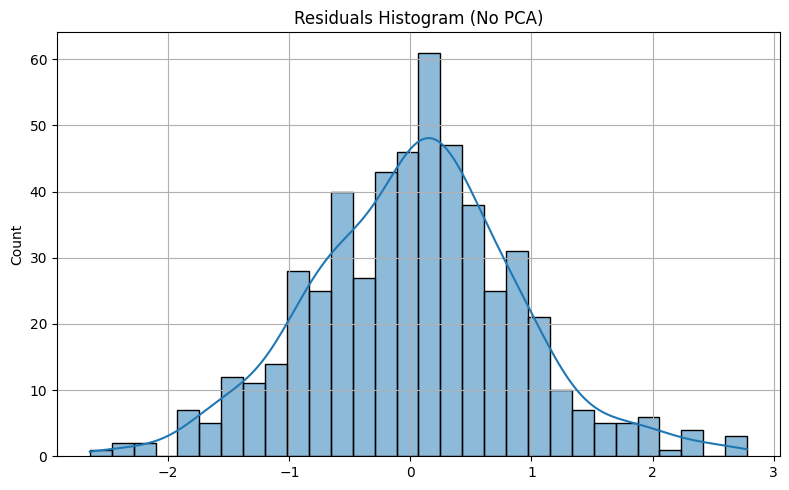

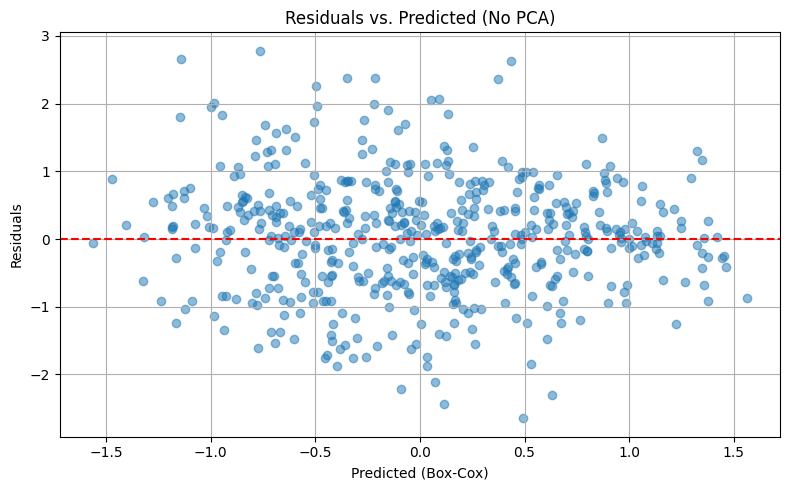

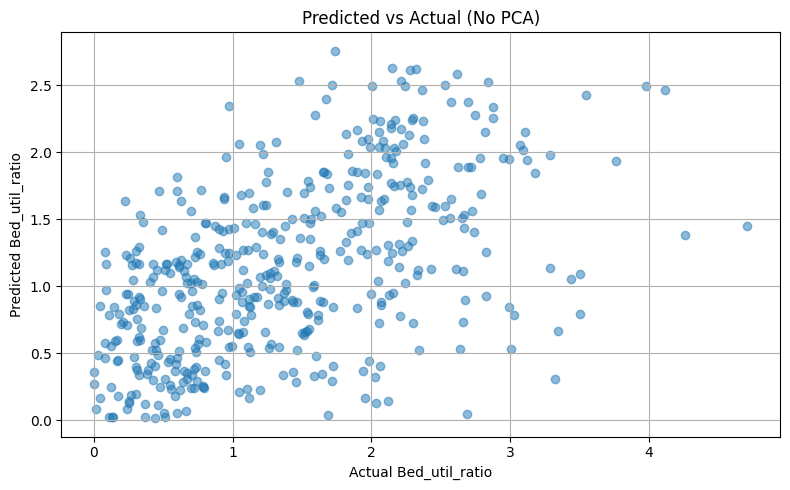


Final RMSE (Original Scale, No PCA): 0.8077
Dropped 69 rows with NaNs from evaluation.


Final RMSE (Original Scale, No PCA): 0.8077


In [28]:
"""
This cell fits a second Support Vector Regression (SVR) model
using the full set of scaled input features (without PCA-based dimensionality reduction).

Purpose:
- To serve as a benchmark and comparison against the SVM model trained on PCA-reduced features
- To assess whether dimensionality reduction via PCA improves, worsens,
or has minimal effect on prediction accuracy

Inputs:
- X_train_scaled, X_test_scaled: Scaled full feature matrices (23 original features,
no dimensionality reduction)
- y_train_bc, y_test_bc: Target variable (Bed_util_ratio), transformed using Box-Cox
to improve normality and stabilize variance

This model:
- Trains an SVR model using the full input space (no PCA)
- Uses 5-fold cross-validation to evaluate training performance (R²)
- Predicts on the Box-Cox transformed test set
- Computes evaluation metrics: RMSE, MAE, and R² on Box-Cox scale
- Performs residual diagnostics:
    - Shapiro-Wilk normality test
    - Histogram and residual scatter plot
- Applies inverse Box-Cox transformation to return predictions to their original scale
- Computes final RMSE in original units and visualizes predicted vs. actual target values
- Handles NaNs resulting from inverse transformation for clean metric reporting

Note:
This section allows side-by-side performance comparison with the PCA-based SVM pipeline
to assess the impact of dimensionality reduction.
"""

# --- SVM Without PCA (on full scaled features) ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import inv_boxcox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM
svm_raw = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv_raw = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_raw = cross_val_score(svm_raw, X_train_scaled, y_train_bc, cv=cv_raw, scoring='r2')

svm_raw.fit(X_train_scaled, y_train_bc)
y_pred_raw_bc = svm_raw.predict(X_test_scaled)

# Evaluate
rmse_raw = np.sqrt(mean_squared_error(y_test_bc, y_pred_raw_bc))
mae_raw = mean_absolute_error(y_test_bc, y_pred_raw_bc)
r2_raw = r2_score(y_test_bc, y_pred_raw_bc)
print(f"CV R² (no PCA): {cv_scores_raw.mean():.4f} ± {cv_scores_raw.std():.4f}")
print(f"Test RMSE: {rmse_raw:.4f}")
print(f"Test MAE:  {mae_raw:.4f}")
print(f"Test R²:   {r2_raw:.4f}")

# Residuals Diagnostics
residuals_raw = y_test_bc - y_pred_raw_bc
stat_raw, p_raw = shapiro(residuals_raw)
print(f"\nShapiro-Wilk (No PCA): W = {stat_raw:.4f}, p = {p_raw:.4f}")
print("Likely Normal" if p_raw > 0.05 else "Not Normal\n")

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals_raw, kde=True, bins=30)
plt.title("Residuals Histogram (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_raw_bc, residuals_raw, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (No PCA)")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform for Interpretation
y_pred_raw_orig = inv_boxcox(y_pred_raw_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred_raw_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure both y_test_orig and y_pred_raw_orig are free of NaNs
valid_mask_raw = ~np.isnan(y_pred_raw_orig) & ~np.isnan(y_test_orig)
rmse_raw_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask_raw], y_pred_raw_orig[valid_mask_raw]))

print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")
print(f"Dropped {(~valid_mask_raw).sum()} rows with NaNs from evaluation.\n")

print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")


In [29]:
print("NaNs in y_pred_raw_orig:", np.isnan(y_pred_raw_orig).sum())


NaNs in y_pred_raw_orig: 6


## SVM Regression on PCA set

CV R² (w/PCA): 0.3002 ± 0.0198
Test RMSE: 0.8661
Test MAE:  0.6691
Test R²:   0.3180

Shapiro-Wilk (w/PCA): W = 0.9937, p = 0.0272
Not Normal



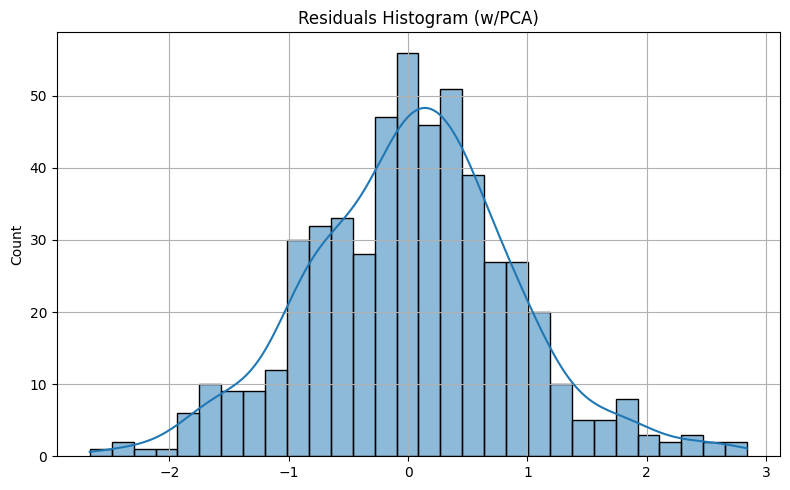

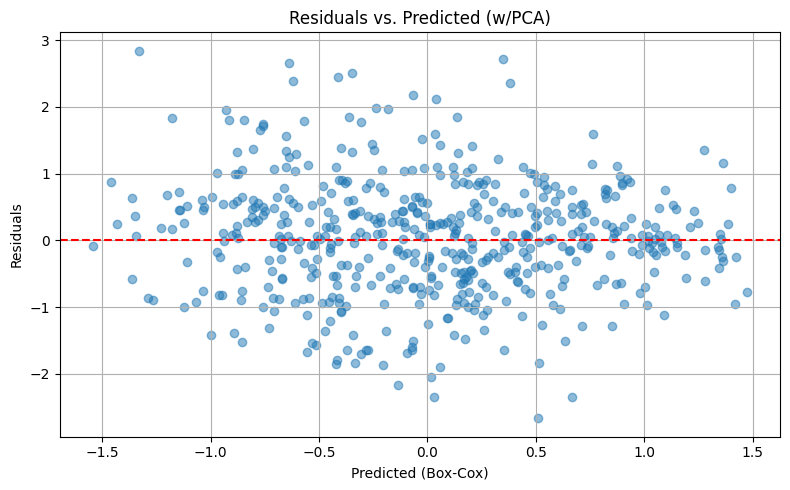

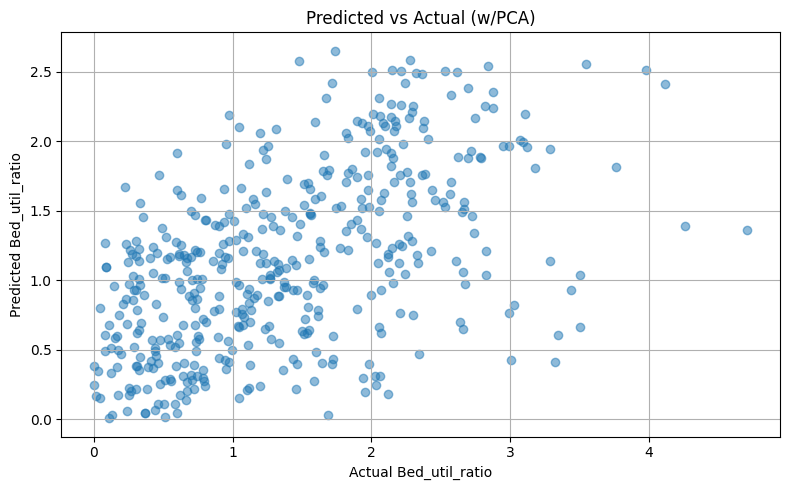


Final RMSE (Original Scale, with PCA): 0.8045
Dropped 71 rows with NaNs from evaluation.


Final RMSE (Original Scale, with PCA): 0.8045


In [30]:
"""
This cell fits a second Support Vector Regression (SVR) model
using the reduced set of scaled input features after PCA dimensionality reduction.

Purpose:
- To serve as a benchmark and comparison against the SVM model trained on PCA-reduced features
- To assess whether dimensionality reduction via PCA improves, worsens,
or has minimal effect on prediction accuracy

Inputs:
- X_train_pca, X_test_pca: Scaled reduced feature matrices (16 features)
- y_train_bc, y_test_bc: Target variable (Bed_util_ratio), transformed using Box-Cox
to improve normality and stabilize variance

This model:
- Trains an SVR model using the PCA-reduced input.
- Uses 5-fold cross-validation to evaluate training performance (R²)
- Predicts on the Box-Cox transformed test set
- Computes evaluation metrics: RMSE, MAE, and R² on Box-Cox scale
- Performs residual diagnostics:
    - Shapiro-Wilk normality test
    - Histogram and residual scatter plot
- Applies inverse Box-Cox transformation to return predictions to their original scale
- Computes final RMSE in original units and visualizes predicted vs. actual target values
- Handles NaNs resulting from inverse transformation for clean metric reporting

Note:
This section allows side-by-side performance comparison with the full set SVM
pipeline to assess the impact of dimensionality reduction.
"""

# --- SVM With PCA ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import inv_boxcox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM
svm_raw = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv_raw = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_raw = cross_val_score(svm_raw, X_train_pca, y_train_bc, cv=cv_raw, scoring='r2')

svm_raw.fit(X_train_pca, y_train_bc)
y_pred_raw_bc = svm_raw.predict(X_test_pca)

# Evaluate
rmse_raw = np.sqrt(mean_squared_error(y_test_bc, y_pred_raw_bc))
mae_raw = mean_absolute_error(y_test_bc, y_pred_raw_bc)
r2_raw = r2_score(y_test_bc, y_pred_raw_bc)
print(f"CV R² (w/PCA): {cv_scores_raw.mean():.4f} ± {cv_scores_raw.std():.4f}")
print(f"Test RMSE: {rmse_raw:.4f}")
print(f"Test MAE:  {mae_raw:.4f}")
print(f"Test R²:   {r2_raw:.4f}")

# Residuals Diagnostics
residuals_raw = y_test_bc - y_pred_raw_bc
stat_raw, p_raw = shapiro(residuals_raw)
print(f"\nShapiro-Wilk (w/PCA): W = {stat_raw:.4f}, p = {p_raw:.4f}")
print("Likely Normal" if p_raw > 0.05 else "Not Normal\n")

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals_raw, kde=True, bins=30)
plt.title("Residuals Histogram (w/PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_raw_bc, residuals_raw, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (w/PCA)")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform for Interpretation
y_pred_raw_orig = inv_boxcox(y_pred_raw_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred_raw_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (w/PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ensure both y_test_orig and y_pred_raw_orig are free of NaNs
valid_mask_raw = ~np.isnan(y_pred_raw_orig) & ~np.isnan(y_test_orig)
rmse_raw_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask_raw], y_pred_raw_orig[valid_mask_raw]))

print(f"\nFinal RMSE (Original Scale, with PCA): {rmse_raw_orig:.4f}")
print(f"Dropped {(~valid_mask_raw).sum()} rows with NaNs from evaluation.\n")

print(f"\nFinal RMSE (Original Scale, with PCA): {rmse_raw_orig:.4f}")


In [31]:
print("NaNs in y_pred_raw_orig:", np.isnan(y_pred_raw_orig).sum())


NaNs in y_pred_raw_orig: 10


## Hyperparameter Tuning & Other Model Tuning

In [32]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import boxcox
from scipy.special import inv_boxcox

def evaluate_and_plot(model, X_train, X_test, y_train, y_test, model_name="Model", lambda_bc=None):
    """
    Evaluates a regression model, prints performance metrics, and generates diagnostic plots.
    Optionally handles Box-Cox transformation for predictions and true values.

    Args:
        model: Trained regression model.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target variable (original scale or Box-Cox).
        y_test: Testing target variable (original scale or Box-Cox).
        model_name: Label for printed metrics and plots.
        lambda_bc: Lambda value used for Box-Cox transformation. If provided,
                   will inverse-transform both predictions and targets.

    Returns:
        None. Prints metrics and shows residual and prediction plots.
    """
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Optional: Inverse Box-Cox transform to original scale
    if lambda_bc is not None:
        epsilon = 1e-6  # Small positive value for numerical stability

        # Clip both predictions AND true values for numerical stability
        y_train_pred = np.clip(y_train_pred, epsilon, None)
        y_test_pred = np.clip(y_test_pred, epsilon, None)
        y_train = np.clip(y_train, epsilon, None)
        y_test = np.clip(y_test, epsilon, None)

        # Debug: show predictions before inverse
        print("\nBefore Inverse Box-Cox")
        print("Predicted (Box-Cox):", y_test_pred[:5])
        print("Actual (Box-Cox):   ", y_test[:5])

        # Inverse Box-Cox (predictions and targets)
        y_train_pred = inv_boxcox(y_train_pred, lambda_bc)
        y_test_pred = inv_boxcox(y_test_pred, lambda_bc)
        y_train = inv_boxcox(y_train, lambda_bc)
        y_test = inv_boxcox(y_test, lambda_bc)

        # Debug: show predictions after inverse
        print("\nAfter Inverse Box-Cox")
        print("Predicted (Original):", y_test_pred[:5])
        print("Actual (Original):   ", y_test[:5])


    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_rmse:.4f} | R²: {train_r2:.4f} | MAE: {train_mae:.4f}")
    print(f"Test  RMSE: {test_rmse:.4f} | R²: {test_r2:.4f} | MAE: {test_mae:.4f}")

    # Residuals
    residuals = y_test - y_test_pred

    # Diagnostic plots
      # Diagnostic plots in separate figures
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f'{model_name} Residuals vs Predicted')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f'{model_name} Residual Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{model_name} Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # sns.scatterplot(x=y_test_pred, y=residuals, ax=axes[0])
    # axes[0].axhline(0, linestyle='--', color='red')
    # axes[0].set_title(f'{model_name} Residuals vs Predicted')
    # axes[0].set_xlabel('Predicted')
    # axes[0].set_ylabel('Residuals')

    # sns.histplot(residuals, kde=True, ax=axes[1])
    # axes[1].set_title(f'{model_name} Residual Distribution')

    # sns.scatterplot(x=y_test, y=y_test_pred, ax=axes[2])
    # axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    # axes[2].set_title(f'{model_name} Predicted vs Actual')
    # axes[2].set_xlabel('Actual')
    # axes[2].set_ylabel('Predicted')

    # plt.tight_layout()
    # plt.show()


# SVR Hyperparameter Tuning (with GridSearchCV - No PCA)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVR Best Params: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}

Support Vector Regression (SVR) Performance:
Train RMSE: 0.1221 | R²: 0.4445 | MAE: 0.0969
Test  RMSE: 0.1410 | R²: 0.3318 | MAE: 0.1090


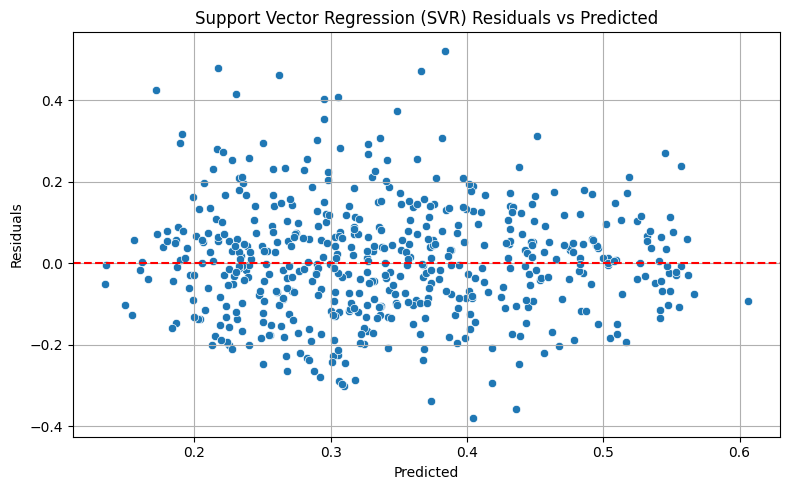

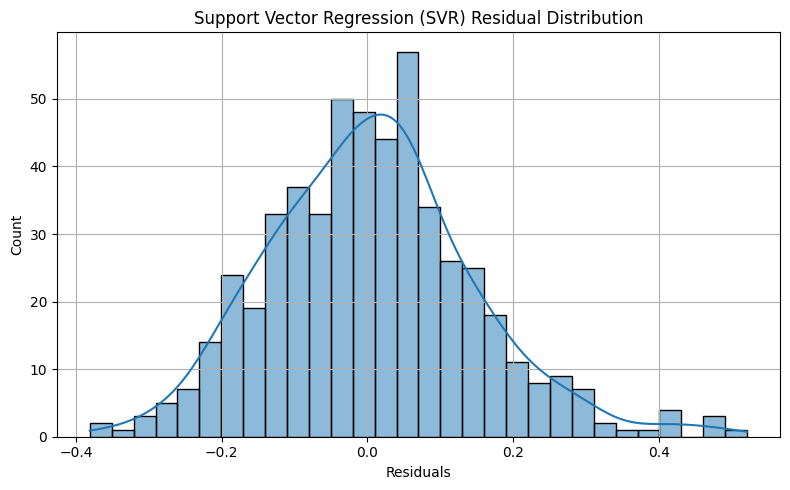

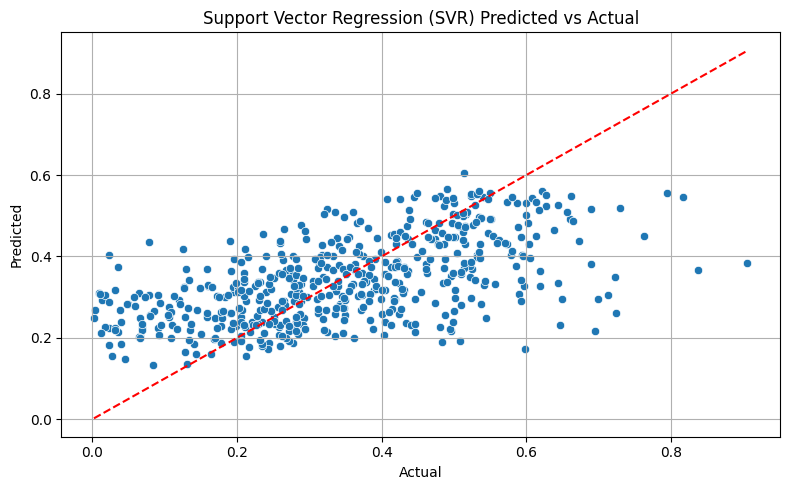

In [33]:
"""
Performs hyperparameter tuning for Support Vector Regression (SVR) using GridSearchCV
and evaluates the best model.

The SVR model is tuned over a predefined set of hyperparameters:
- 'C': [0.1, 1, 10] (regularization parameter)
- 'epsilon': [0.01, 0.1] (tube width)
- 'kernel': ['linear', 'rbf'] (kernel type)

GridSearchCV uses the specified cross-validation strategy (`cv_strategy`) and
neg_mean_squared_error as the scoring metric to find the optimal combination
of hyperparameters.

After fitting the GridSearchCV object, the best estimator is retrieved,
its best parameters are printed, and the `evaluate_and_plot` function is
called to assess its performance on the scaled training and testing data,
generating relevant evaluation metrics and diagnostic plots.
"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# SVR Tuning
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1],
    'kernel': ['linear', 'rbf', 'poly']
}

svr_grid = GridSearchCV(SVR(), svr_params, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
svr_grid.fit(X_train_scaled, y_train)

# SVR Evaluation
svr_best = svr_grid.best_estimator_
print("SVR Best Params:", svr_grid.best_params_)
evaluate_and_plot(svr_best, X_train_scaled, X_test_scaled, y_train, y_test, "Support Vector Regression (SVR)")


# SVR on PCA-Reduced Features


Performing Grid Search for SVR (PCA-reduced)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVR (PCA) Best Parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.00000000e-06 8.24025461e-01 4.46641835e-01 1.31521965e-01
 1.00000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.88346861 1.46514476 1.13321732 1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

SVR with PCA Performance:
Train RMSE: 0.5210 | R²: 0.3062 | MAE: 0.2748
Test  RMSE: 0.6176 | R²: 0.1796 | MAE: 0.3581


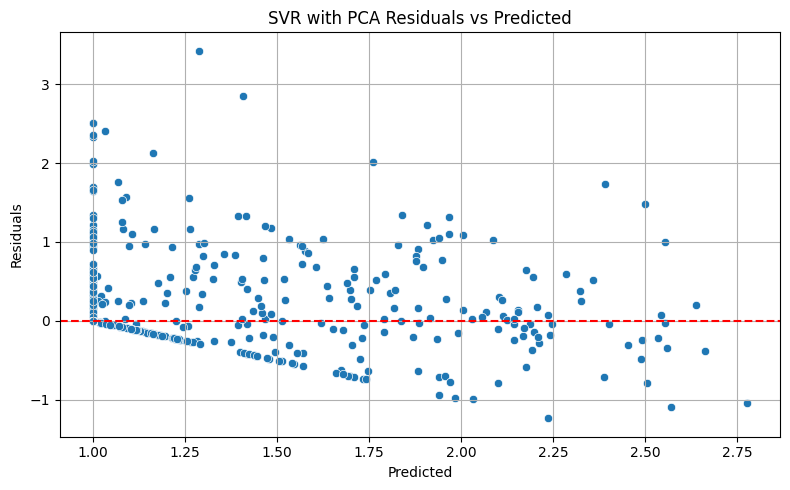

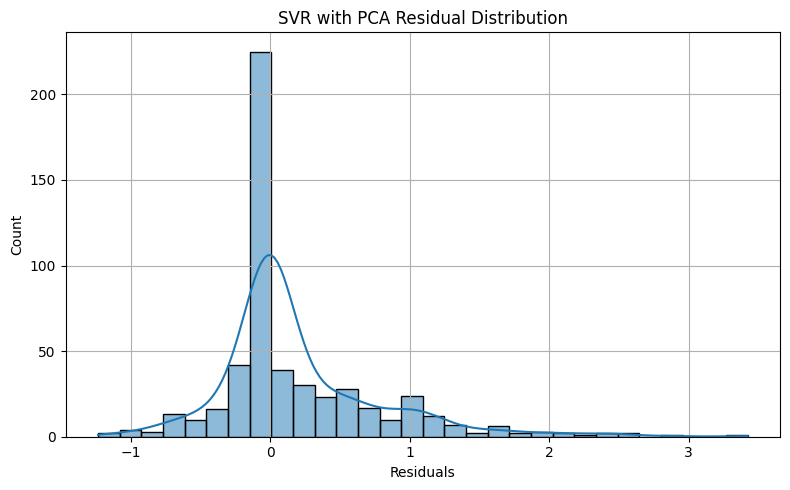

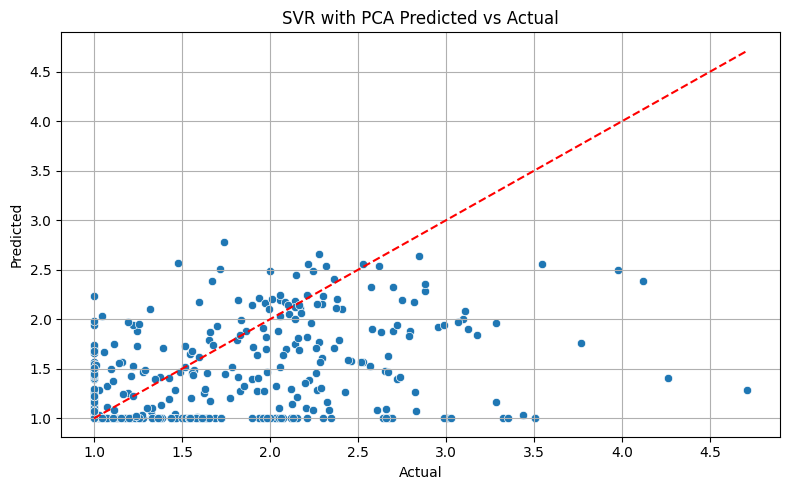

In [34]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox


# Support Vector Regression with PCA-Reduced Features
print("\nPerforming Grid Search for SVR (PCA-reduced)...")
svr_params = {
    'C': [1, 10, 100],
    'epsilon': [0.001, 0.01],
    'kernel': ['rbf']
}

svr_grid_pca = GridSearchCV(
    estimator=SVR(),
    param_grid=svr_params,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

svr_grid_pca.fit(X_train_pca, y_train_bc)
svr_best_pca = svr_grid_pca.best_estimator_

print("SVR (PCA) Best Parameters:", svr_grid_pca.best_params_)

# Use updated evaluation with inverse Box-Cox
evaluate_and_plot(
    svr_best_pca,
    X_train_pca,
    X_test_pca,
    y_train_bc,
    y_test_bc,
    model_name="SVR with PCA",
    lambda_bc=lambda_bc
)


# Random Forest Regressor (with GridSearchCV - No PCA)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Regression Performance:
Train RMSE: 0.1185 | R²: 0.4768 | MAE: 0.0939
Test  RMSE: 0.1388 | R²: 0.3524 | MAE: 0.1063


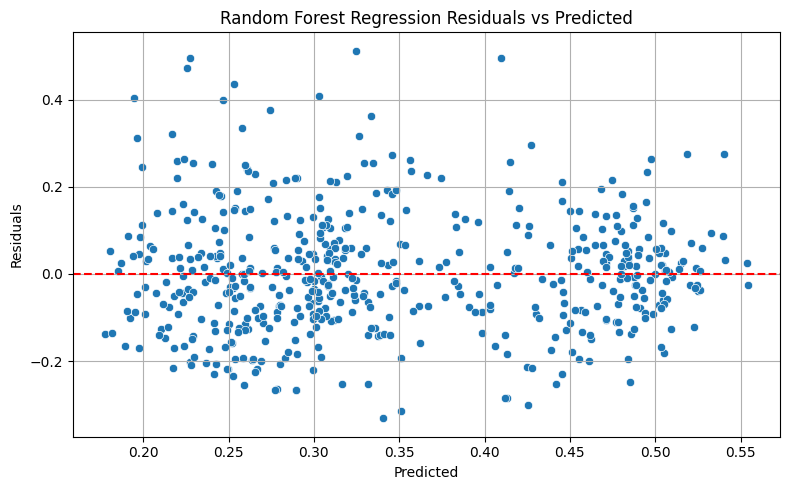

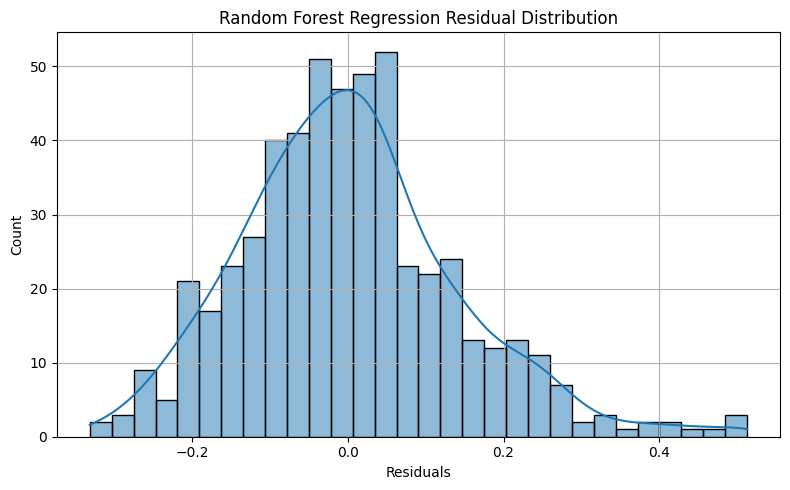

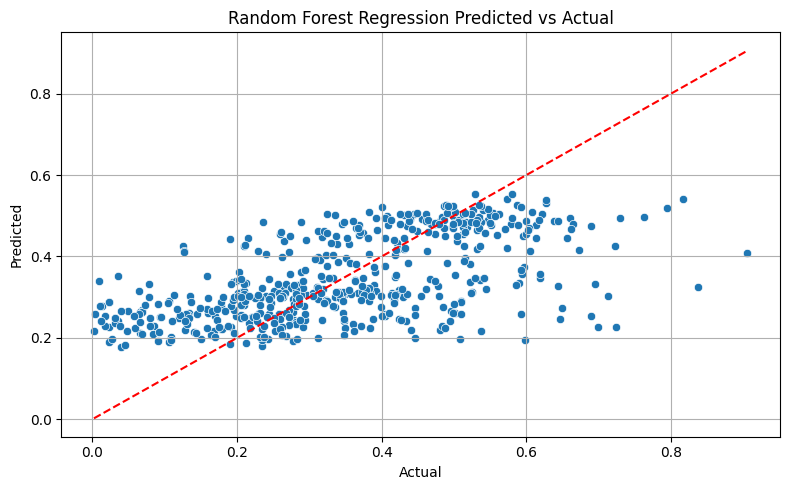

In [35]:
"""
Performs hyperparameter tuning for Random Forest Regression using GridSearchCV
and evaluates the best model.

The Random Forest Regressor is tuned over the following hyperparameters:
- 'n_estimators': [100, 200] (number of trees in the forest)
- 'max_depth': [5, 10, None] (maximum depth of the trees)
- 'min_samples_split': [2, 5] (minimum number of samples required to split an internal node)

GridSearchCV uses the specified cross-validation strategy (`cv_strategy`) and
neg_mean_squared_error as the scoring metric to find the optimal combination
of hyperparameters. A fixed `random_state` is used for reproducibility.

After fitting the GridSearchCV object, the best estimator is retrieved,
its best parameters are printed, and the `evaluate_and_plot` function is
called to assess its performance on the scaled training and testing data,
generating relevant evaluation metrics and diagnostic plots.
"""

# Random Forest Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=cv_strategy,
                       scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

# RF Evaluation
rf_best = rf_grid.best_estimator_
print("Random Forest Best Params:", rf_grid.best_params_)
evaluate_and_plot(rf_best, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest Regression")



### Random Forest on PCA-Reduced Features

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest (PCA) Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.00000000e-06 7.30546436e-01 2.50474756e-01 1.94178313e-01
 1.00000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.77790838 1.25649171 1.19783126 1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

Random Forest with PCA Performance:
Train RMSE: 0.3698 | R²: 0.6505 | MAE: 0.1987
Test  RMSE: 0.6214 | R²: 0.1695 | MAE: 0.3608


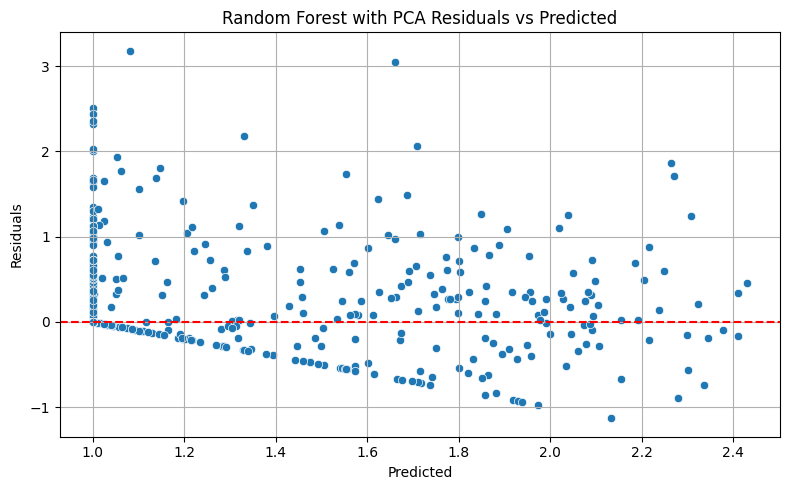

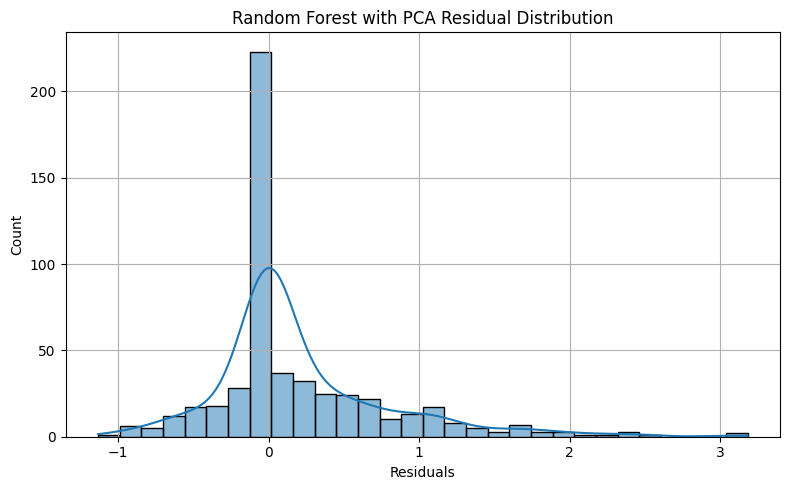

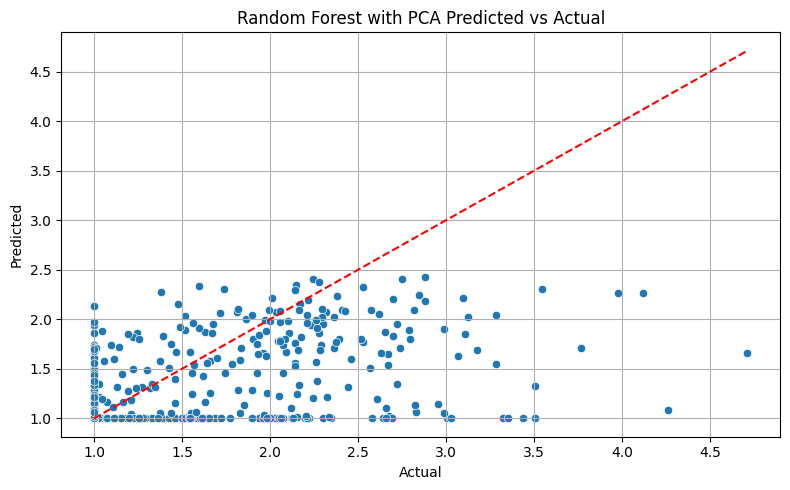

In [36]:
rf_grid_pca = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

rf_grid_pca.fit(X_train_pca, y_train_bc)
rf_best_pca = rf_grid_pca.best_estimator_
print("Random Forest (PCA) Best Params:", rf_grid_pca.best_params_)
evaluate_and_plot(rf_best_pca, X_train_pca, X_test_pca, y_train_bc, y_test_bc, "Random Forest with PCA", lambda_bc=lambda_bc)


# Gradient Boosting Regressor (with GridSearchCV - No PCA)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Gradient Boosting Regression Performance:
Train RMSE: 0.1156 | R²: 0.5018 | MAE: 0.0917
Test  RMSE: 0.1384 | R²: 0.3558 | MAE: 0.1061


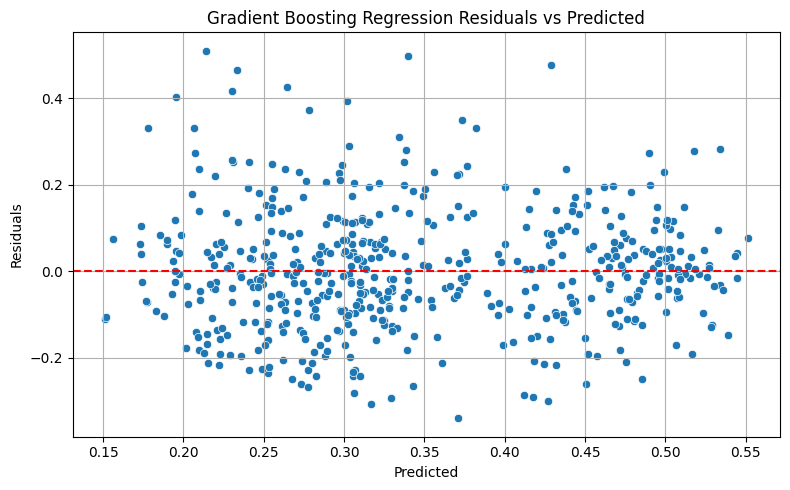

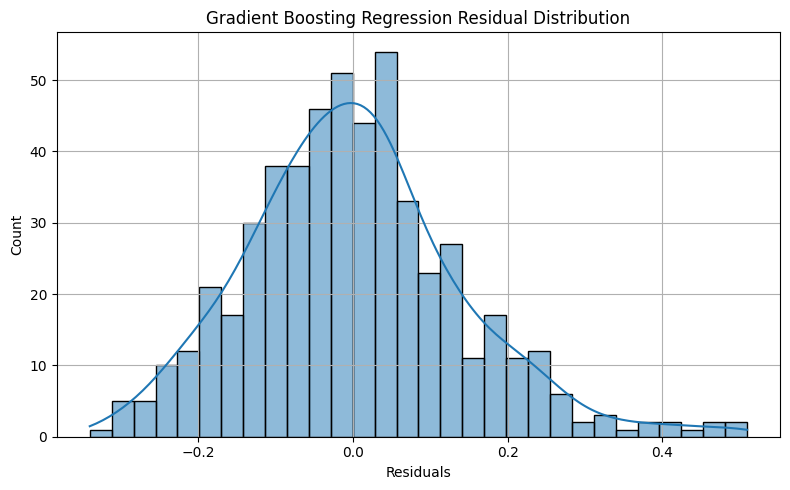

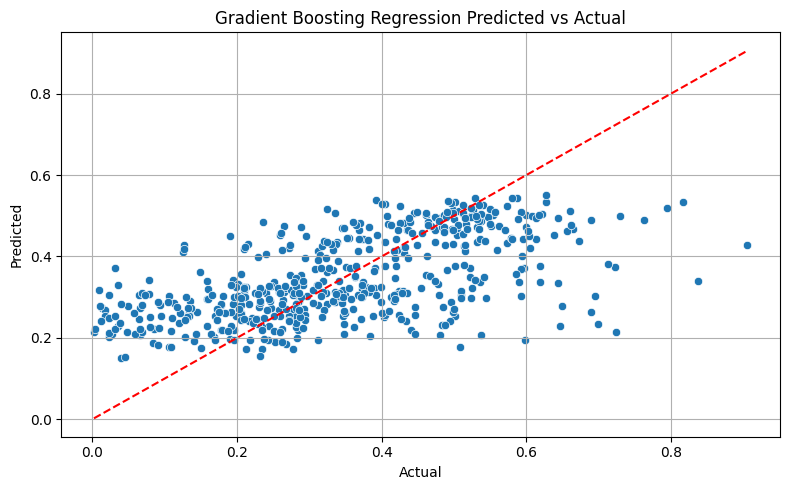

In [37]:
"""
Performs hyperparameter tuning for Gradient Boosting Regression using GridSearchCV
and evaluates the best model.

The Gradient Boosting Regressor is tuned over the following hyperparameters:
- 'learning_rate': [0.05, 0.1] (learning rate of the gradient boosting)
- 'n_estimators': [100, 200] (number of boosting stages to perform)
- 'max_depth': [3, 5] (maximum depth of the individual regression estimators)

GridSearchCV uses the specified cross-validation strategy (`cv_strategy`) and
neg_mean_squared_error as the scoring metric to find the optimal combination
of hyperparameters. A fixed `random_state` is used for reproducibility.

After fitting the GridSearchCV object, the best estimator is retrieved,
its best parameters are printed, and the `evaluate_and_plot` function is
called to assess its performance on the scaled training and testing data,
generating relevant evaluation metrics and diagnostic plots.
"""

# Gradient Boosting Tuning
gb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=cv_strategy,
                       scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid.fit(X_train_scaled, y_train)

# GB Evaluation
gb_best = gb_grid.best_estimator_
print("Gradient Boosting Best Params:", gb_grid.best_params_)
evaluate_and_plot(gb_best, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting Regression")


### Gradient Boosting on PCA-Reduced Features

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting (PCA) Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.00000000e-06 7.49345598e-01 4.55176670e-01 4.23353687e-02
 1.00000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.79903847 1.47436667 1.04251405 1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

Gradient Boosting with PCA Performance:
Train RMSE: 0.5393 | R²: 0.2566 | MAE: 0.3068
Test  RMSE: 0.6325 | R²: 0.1395 | MAE: 0.3686


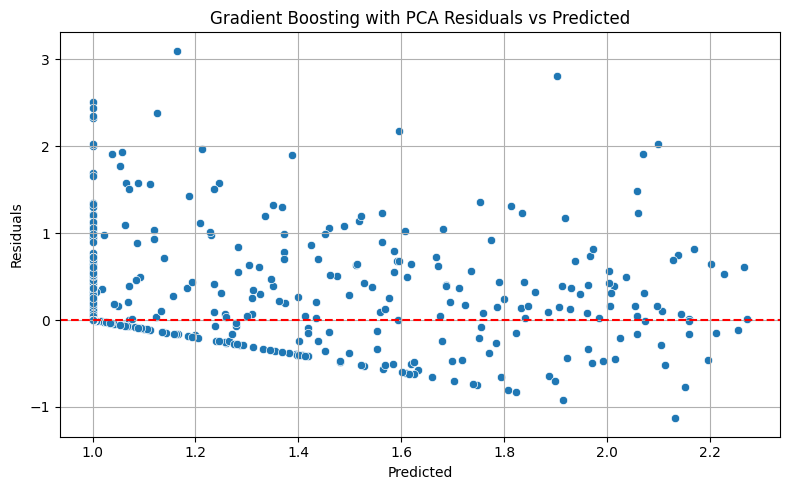

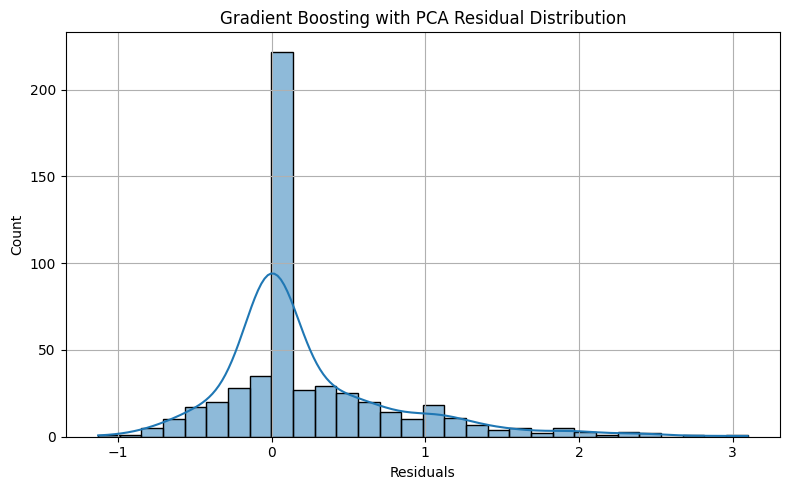

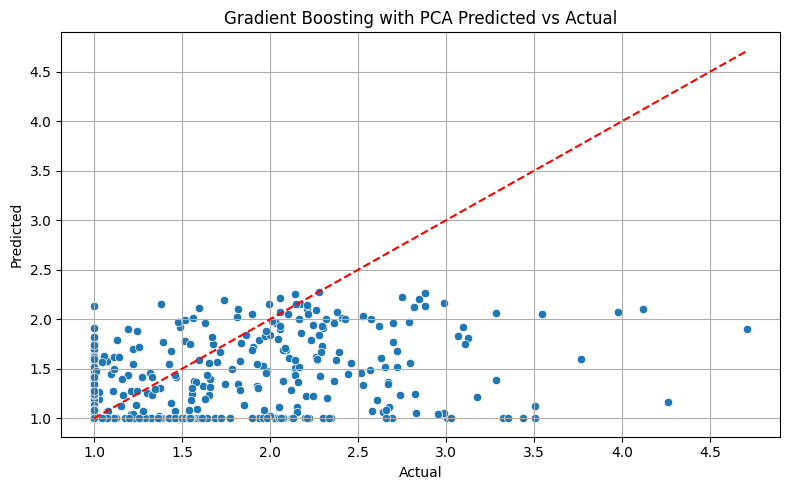

In [38]:
gb_grid_pca = GridSearchCV(GradientBoostingRegressor(random_state=42), {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

gb_grid_pca.fit(X_train_pca, y_train_bc)
gb_best_pca = gb_grid_pca.best_estimator_
print("Gradient Boosting (PCA) Best Params:", gb_grid_pca.best_params_)
evaluate_and_plot(gb_best_pca, X_train_pca, X_test_pca, y_train_bc, y_test_bc, "Gradient Boosting with PCA", lambda_bc=lambda_bc)


# XGBoost Regressor (with GridSearchCV - No PCA)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

XGBoost Regression Performance:
Train RMSE: 0.1163 | R²: 0.4956 | MAE: 0.0917
Test  RMSE: 0.1378 | R²: 0.3617 | MAE: 0.1057


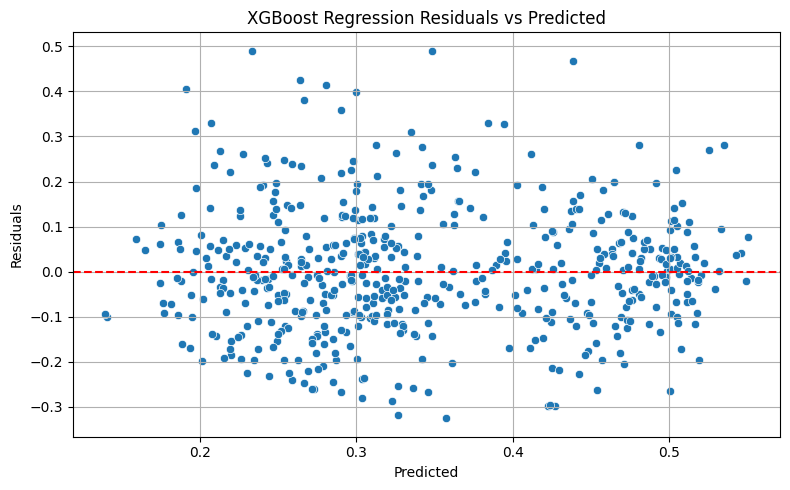

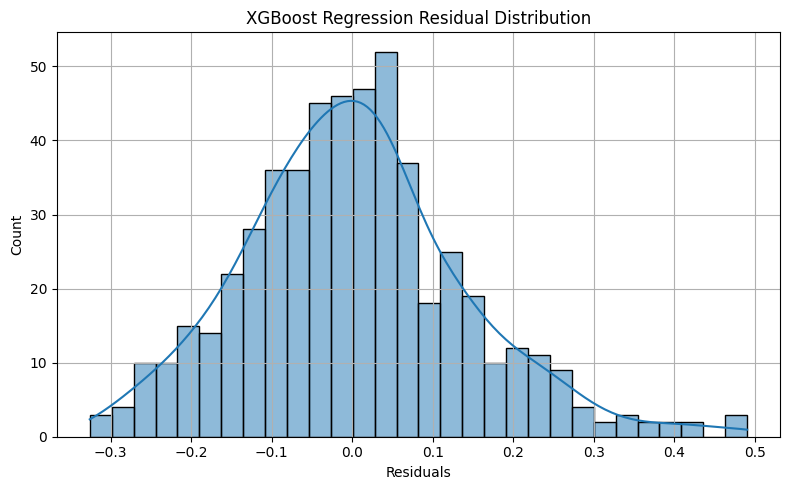

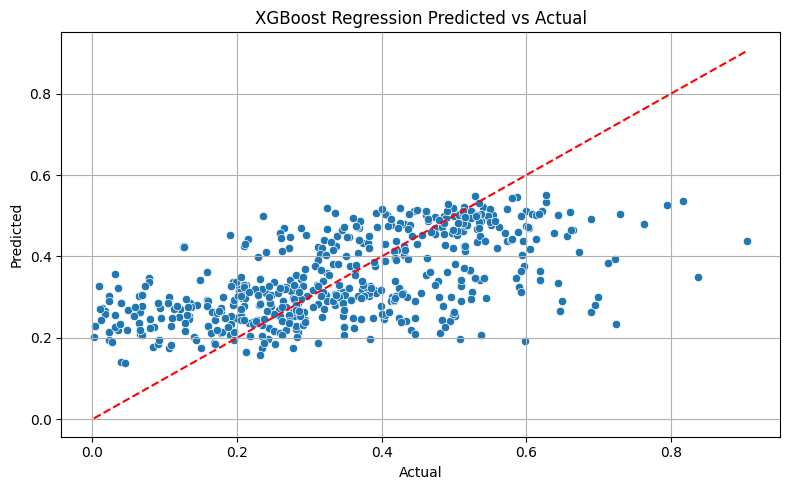

In [39]:
"""
Performs hyperparameter tuning for Random Forest Regression using GridSearchCV
and evaluates the best model.

The Random Forest Regressor is tuned over the following hyperparameters:
- 'n_estimators': [100, 200] (number of trees in the forest)
- 'max_depth': [5, 10, None] (maximum depth of the trees)
- 'min_samples_split': [2, 5] (minimum number of samples required to split an internal node)

GridSearchCV uses the specified cross-validation strategy (`cv_strategy`) and
neg_mean_squared_error as the scoring metric to find the optimal combination
of hyperparameters. A fixed `random_state` is used for reproducibility.

After fitting the GridSearchCV object, the best estimator is retrieved,
its best parameters are printed, and the `evaluate_and_plot` function is
called to assess its performance on the scaled training and testing data,
generating relevant evaluation metrics and diagnostic plots.
"""
# XGBoost Tuning
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

xgb_grid = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_params, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
xgb_grid.fit(X_train_scaled, y_train)

# XGBoost Evaluation
xgb_best = xgb_grid.best_estimator_
print("XGBoost Best Params:", xgb_grid.best_params_)
evaluate_and_plot(xgb_best, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost Regression")


### XGBoost on PCA-Reduced Features

Fitting 5 folds for each of 8 candidates, totalling 40 fits
XGBoost (PCA) Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.0000000e-06 7.5360316e-01 4.2370069e-01 6.9371104e-02 1.0000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.8038309  1.44041469 1.06984835 1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

XGBoost with PCA Performance:
Train RMSE: 0.5445 | R²: 0.2421 | MAE: 0.3083
Test  RMSE: 0.6326 | R²: 0.1393 | MAE: 0.3668


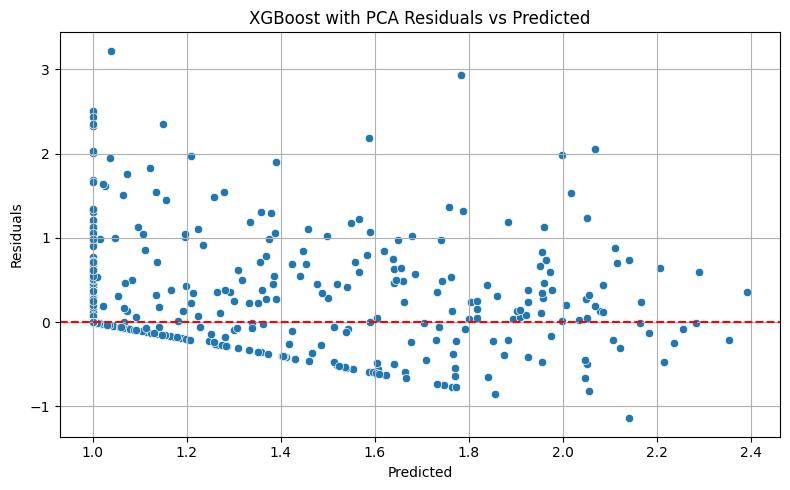

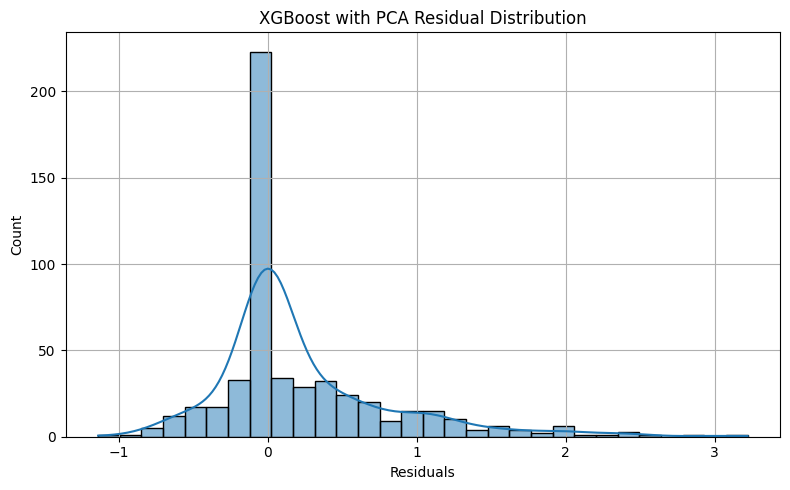

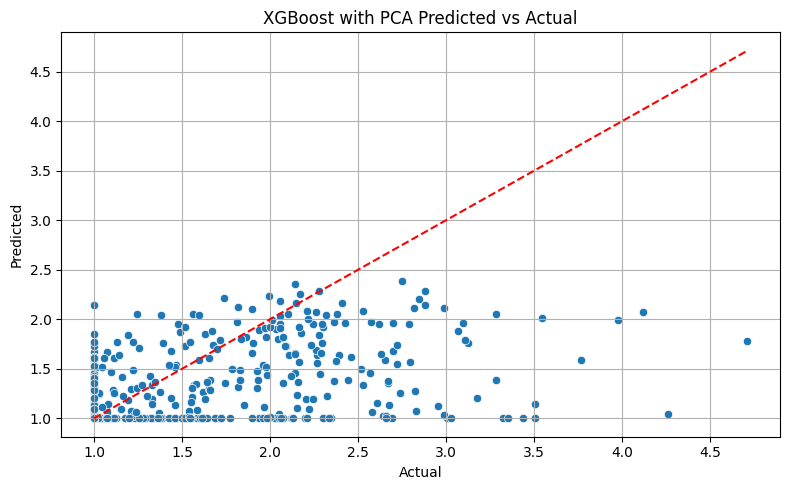

In [40]:
xgb_grid_pca = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42), {
        'learning_rate': [0.05, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 5]
    }, cv=cv_strategy, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

xgb_grid_pca.fit(X_train_pca, y_train_bc)
xgb_best_pca = xgb_grid_pca.best_estimator_
print("XGBoost (PCA) Best Params:", xgb_grid_pca.best_params_)
evaluate_and_plot(xgb_best_pca, X_train_pca, X_test_pca, y_train_bc, y_test_bc, "XGBoost with PCA", lambda_bc=lambda_bc)


# Updated XGBoost Tuning Grid w/ PCA (with Regularization + Simpler Trees)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters (XGBoost w/ PCA - Updated): {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.0000000e-06 8.3516115e-01 4.0852004e-01 4.6587106e-02 1.0000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.89612448 1.424097   1.0468033  1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

XGBoost with PCA (Updated) Performance:
Train RMSE: 0.4999 | R²: 0.3613 | MAE: 0.2858
Test  RMSE: 0.6184 | R²: 0.1773 | MAE: 0.3587


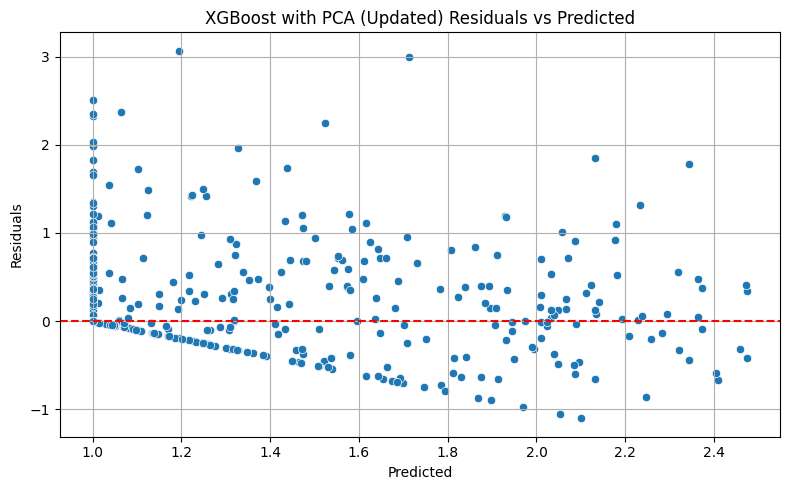

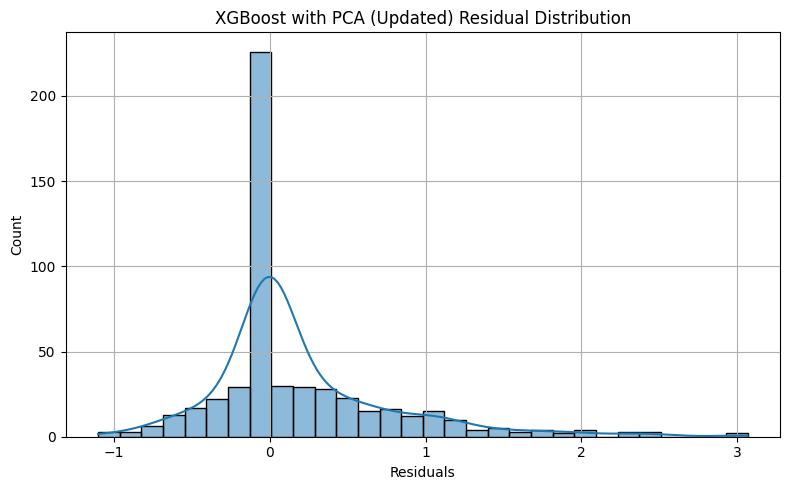

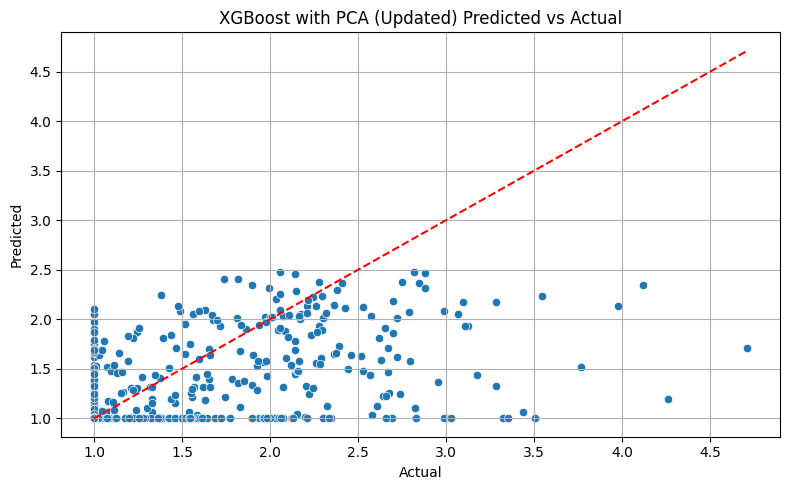

In [41]:
from sklearn.model_selection import GridSearchCV

xgb_params_updated = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [2, 3, 5],  # smaller trees to reduce overfitting
    'subsample': [0.6, 0.8, 1.0],  # only use a fraction of rows per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # only use a fraction of features per tree
    'gamma': [0, 0.1, 0.3]  # regularization on splits
}

xgb_grid_pca_updated = GridSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=0,
        n_jobs=-1
    ),
    param_grid=xgb_params_updated,
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid_pca_updated.fit(X_train_pca, y_train_bc)
xgb_best_pca_updated = xgb_grid_pca_updated.best_estimator_

print("Best Parameters (XGBoost w/ PCA - Updated):", xgb_grid_pca_updated.best_params_)

# Evaluation
evaluate_and_plot(
    xgb_best_pca_updated,
    X_train_pca,
    X_test_pca,
    y_train_bc,
    y_test_bc,
    model_name="XGBoost with PCA (Updated)",
    lambda_bc=lambda_bc
)


# FURTHER TUNING FOR MODEL W/ BEST POTENTIAL

#  SVR (Support Vector Regression) Expanded Tuning Grid - No PCA

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (Expanded SVR - No PCA): {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.00000000e-06 7.61412489e-01 2.89060047e-01 1.36496575e-01
 1.00000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.81262793 1.29701933 1.1383209  1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

SVR (Expanded, No PCA) Performance:
Train RMSE: 0.5691 | R²: 0.1721 | MAE: 0.3212
Test  RMSE: 0.6271 | R²: 0.1542 | MAE: 0.3659


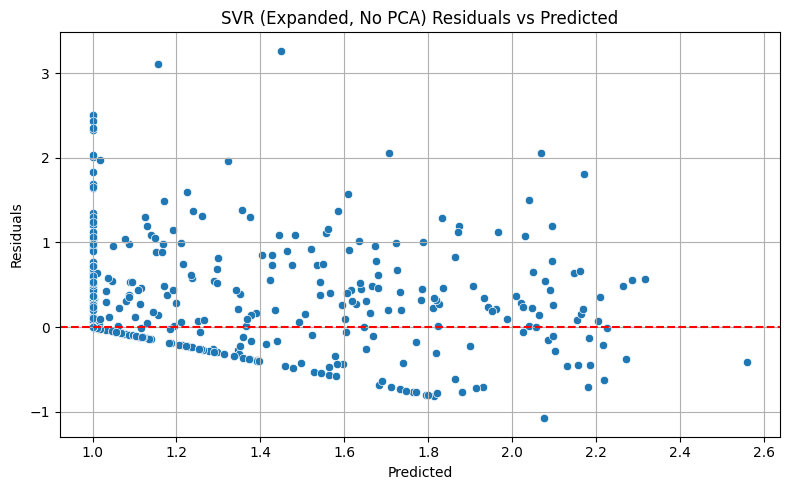

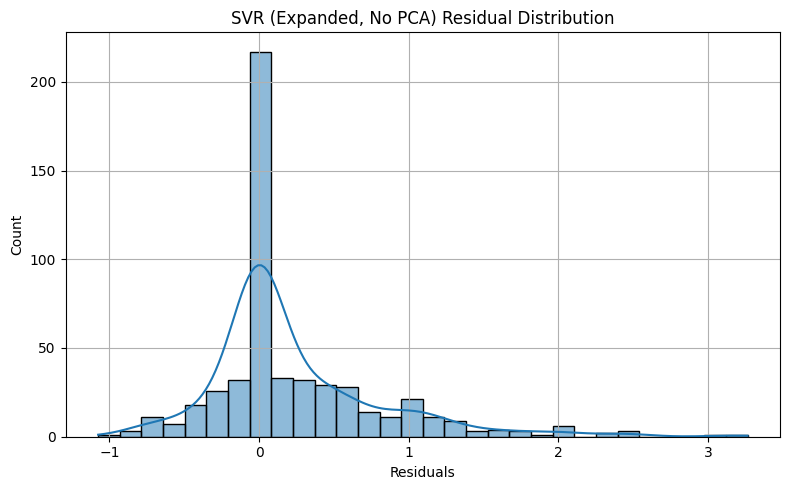

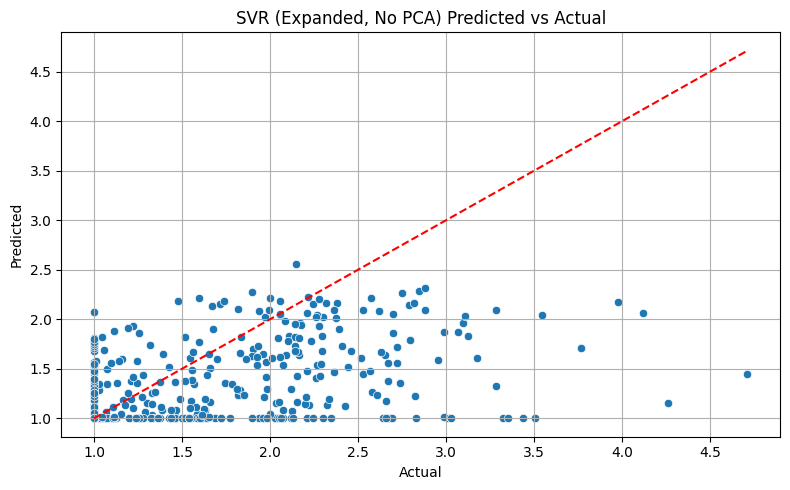

In [42]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR

# Cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Expanded SVR Hyperparameter Grid (No PCA)
svr_params_expanded = {
    'C': [0.01, 0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

svr_grid_expanded = GridSearchCV(
    estimator=SVR(),
    param_grid=svr_params_expanded,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Fit the expanded grid
svr_grid_expanded.fit(X_train_scaled, y_train_bc)

# Evaluate
svr_best_expanded = svr_grid_expanded.best_estimator_
print("Best Parameters (Expanded SVR - No PCA):", svr_grid_expanded.best_params_)

evaluate_and_plot(
    svr_best_expanded,
    X_train_scaled,
    X_test_scaled,
    y_train_bc,
    y_test_bc,
    model_name="SVR (Expanded, No PCA)",
    lambda_bc=lambda_bc
)


# XGBoost Tuning (No PCA – Expanded Grid)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters (Expanded XGBoost - No PCA): {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Before Inverse Box-Cox
Predicted (Box-Cox): [1.0000000e-06 7.1305263e-01 6.1930394e-01 1.0000000e-06 1.0000000e-06]
Actual (Box-Cox):    [1.00000000e-06 9.63249262e-01 9.11773423e-01 1.00000000e-06
 1.00000000e-06]

After Inverse Box-Cox
Predicted (Original): [1.000001   1.75829073 1.65391601 1.000001   1.000001  ]
Actual (Original):    [1.000001   2.04290478 1.98365293 1.000001   1.000001  ]

XGBoost (Expanded, No PCA) Performance:
Train RMSE: 0.5259 | R²: 0.2929 | MAE: 0.2950
Test  RMSE: 0.6094 | R²: 0.2012 | MAE: 0.3480


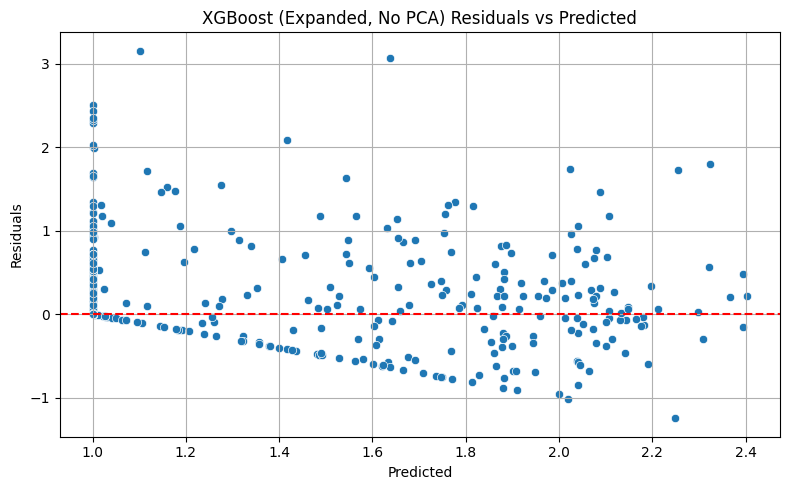

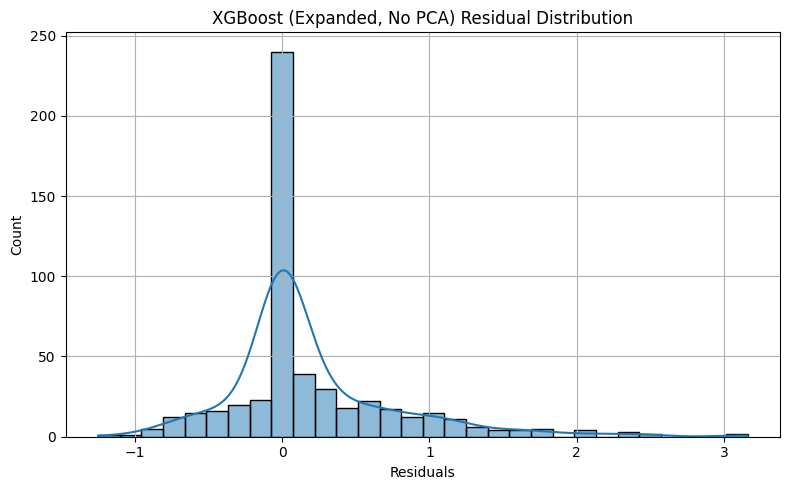

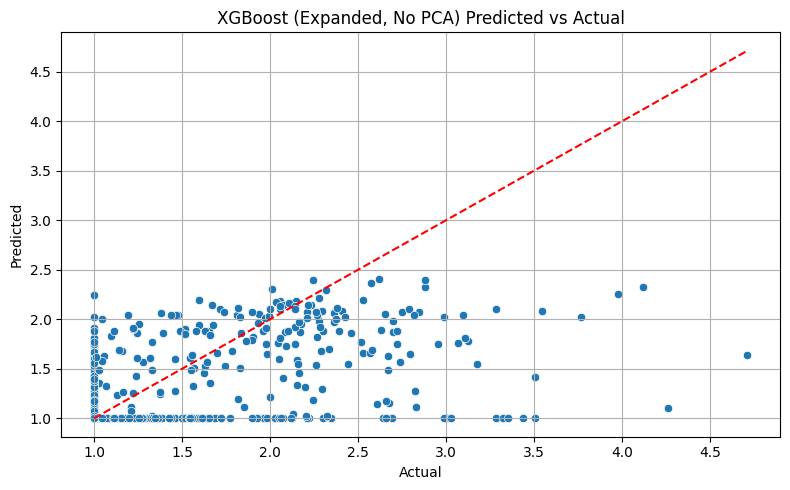

In [43]:
from sklearn.model_selection import KFold

# Define cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Expanded XGBoost Hyperparameter Grid (No PCA)
xgb_params_expanded = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_grid_expanded = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=xgb_params_expanded,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Fit the expanded grid
xgb_grid_expanded.fit(X_train_scaled, y_train_bc)

# Evaluate
xgb_best_expanded = xgb_grid_expanded.best_estimator_
print("Best Parameters (Expanded XGBoost - No PCA):", xgb_grid_expanded.best_params_)

evaluate_and_plot(
    xgb_best_expanded,
    X_train_scaled,
    X_test_scaled,
    y_train_bc,
    y_test_bc,
    model_name="XGBoost (Expanded, No PCA)",
    lambda_bc=lambda_bc
)
